# Additional algorithm examples

Here, we implement the additional examples from the appendix.

In [1]:
import haiku as hk
%matplotlib inline
import matplotlib.pyplot as plt
import sbijax

from jax import numpy as jnp, random as jr
from tensorflow_probability.substrates.jax import distributions as tfd

## Generative model

We follow the example in the appendix and use the following generative model

\begin{align}
\theta &\sim \mathcal{N}_2(0, I)\\
y \mid \theta &\sim 0.5 \ \mathcal{N}_2(\theta, I) + 0.5 \ \mathcal{N}_2(\theta, 0.01 I)
\end{align}

In [2]:
def prior_fn():
    prior = tfd.JointDistributionNamed(dict(
        theta=tfd.Normal(jnp.zeros(2), 1)
    ), batch_ndims=0)
    return prior


def simulator_fn(seed, theta):
    mean = theta["theta"].reshape(-1, 2)
    n = mean.shape[0]
    data_key, cat_key = jr.split(seed)
    pi_categories = tfd.Categorical(logits=jnp.zeros(2))
    categories = pi_categories.sample(seed=cat_key, sample_shape=(n,))
    scales = jnp.array([1.0, 0.1])[categories].reshape(-1, 1)
    y = tfd.Normal(mean, scales).sample(seed=data_key)
    return y

## Observation

In [3]:
y_observed = jnp.array([-1.0, 1.0])

## NUTS 

In [4]:
import arviz as az
from sbijax import as_inference_data
from sbijax.mcmc import sample_with_nuts
from functools import partial

In [5]:
def likelihood_fn(y, theta):
    mean = theta["theta"].reshape(1, 2)
    mix = tfd.Categorical(logits=jnp.zeros(2))
    likelihood = tfd.MixtureSameFamily(
        mixture_distribution=mix,
        components_distribution=tfd.MultivariateNormalDiag(
            jnp.concatenate([mean, mean], axis=0),
            jnp.concatenate([jnp.full((1, 2), 1.0), jnp.full((1, 2), 0.01)], axis=0),
        )
    )
    ll = likelihood.log_prob(y)
    return ll

In [6]:
def log_density_fn(theta, y):
    prior_lp = prior_fn().log_prob(theta)
    likelihood_lp = likelihood_fn(y, theta)
    lp = jnp.sum(prior_lp) + jnp.sum(likelihood_lp)
    return lp

In [7]:
log_density_partial = partial(log_density_fn, y=y_observed)
samples = sample_with_nuts(
    jr.PRNGKey(0),
    log_density_partial,
    prior_fn().sample
)
inference_results = as_inference_data(samples, jnp.squeeze(y_observed))

In [8]:
az.ess(inference_results, relative=True)

<xarray.Dataset> Size: 32B
Dimensions:    (theta_dim: 2)
Coordinates:
  * theta_dim  (theta_dim) int64 16B 0 1
Data variables:
    theta      (theta_dim) float64 16B 0.9817 1.003

In [9]:
az.rhat(inference_results)

<xarray.Dataset> Size: 32B
Dimensions:    (theta_dim: 2)
Coordinates:
  * theta_dim  (theta_dim) int64 16B 0 1
Data variables:
    theta      (theta_dim) float64 16B 1.001 0.9999

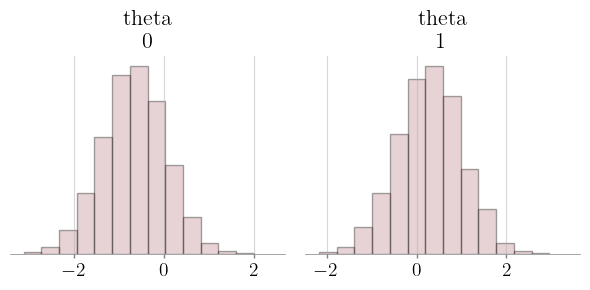

In [10]:
_, axes = plt.subplots(figsize=(6, 3), ncols=2)
sbijax.plot_posterior(inference_results, axes=axes)
plt.tight_layout()
plt.savefig("figs/appendix-mixture_model-nuts.pdf", dpi=200)
plt.show()

## CMPE

In [11]:
import optax
from sbijax import CMPE
from sbijax._src.nn.make_consistency_model import ConsistencyModel

In [12]:
def make_model(dim):
    @hk.transform
    def _mlp(method, **kwargs):
        def _c_skip(time):
            return 1 / ((time - 0.001) ** 2 + 1)

        def _c_out(time):
            return 1.0 * (time - 0.001) / jnp.sqrt(1 + time**2)

        def _nn(theta, time, context, **kwargs):
            ins = jnp.concatenate([theta, time, context], axis=-1)
            outs = hk.nets.MLP([64, 64, dim])(ins)
            out_skip = _c_skip(time) * theta + _c_out(time) * outs
            return out_skip

        cm = ConsistencyModel(dim, _nn)
        return cm(method, **kwargs)

    return _mlp

In [13]:
fns = prior_fn, simulator_fn
model = CMPE(fns, make_model(2))

data, _ = model.simulate_data(jr.PRNGKey(1), n_simulations=10_000)
params, info = model.fit(
    jr.PRNGKey(2),
    data=data,
    optimizer=optax.adam(1e-3),
    n_early_stopping_patience=25
)

 12%|████████████████▉                                                                                                                          | 122/1000 [00:33<04:01,  3.64it/s]


In [14]:
inference_results, _ = model.sample_posterior(jr.PRNGKey(3), params, y_observed)

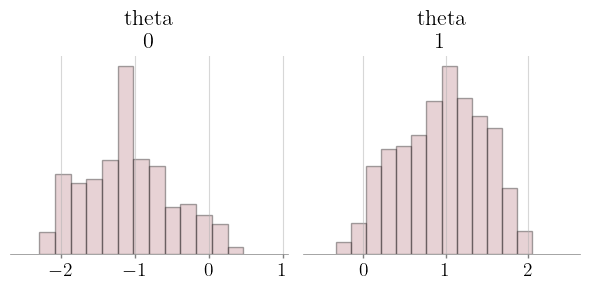

In [15]:
_, axes = plt.subplots(figsize=(6, 3), ncols=2)
sbijax.plot_posterior(inference_results, axes=axes)
plt.tight_layout()
plt.savefig("figs/appendix-mixture_model-cmpe.pdf", dpi=200)
plt.show()

## NRE

In [16]:
from sbijax import NRE

In [17]:
def make_model():
    @hk.without_apply_rng
    @hk.transform
    def _mlp(inputs, **kwargs):
        return hk.nets.MLP([64, 64, 1])(inputs)

    return _mlp

In [18]:
fns = prior_fn, simulator_fn
model = NRE(fns, make_model())

data, _ = model.simulate_data(
    jr.PRNGKey(1), n_simulations=10000
)
params, info = model.fit(
    jr.PRNGKey(2),
    data=data,
    optimizer=optax.adam(1e-3),    
    n_early_stopping_patience=25
)

  4%|█████▉                                                                                                                                      | 42/1000 [00:41<15:51,  1.01it/s]


In [19]:
inference_results, _ = model.sample_posterior(jr.PRNGKey(3), params, y_observed)

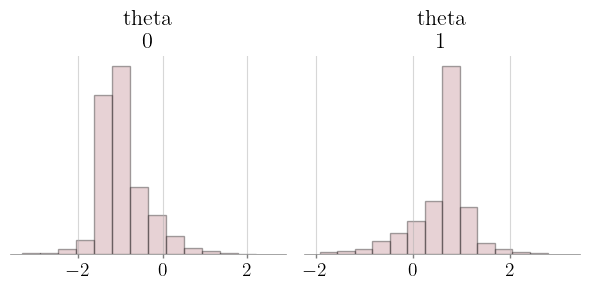

In [20]:
_, axes = plt.subplots(figsize=(6, 3), ncols=2)
sbijax.plot_posterior(inference_results, axes=axes)
plt.tight_layout()
plt.savefig("figs/appendix-mixture_model-nre.pdf", dpi=200)
plt.show()

## NPE

In [21]:
from sbijax import NPE
from surjectors import (
    Chain,
    MaskedAutoregressive,
    Permutation,
    ScalarAffine,
    TransformedDistribution,
)
from surjectors.nn import MADE
from surjectors.util import unstack

In [22]:
def make_flow(dim):
    def _bijector_fn(params):
        means, log_scales = unstack(params, -1)
        return ScalarAffine(means, jnp.exp(log_scales))

    def _flow(method, **kwargs):
        layers = []
        order = jnp.arange(dim)
        for i in range(5):
            layer = MaskedAutoregressive(
                bijector_fn=_bijector_fn,
                conditioner=MADE(
                    dim, [50, 50], 2,
                    w_init=hk.initializers.TruncatedNormal(0.001),
                    b_init=jnp.zeros,                    
                ),
            )
            order = order[::-1]
            layers.append(layer)
            layers.append(Permutation(order, 1))
        chain = Chain(layers)

        base_distribution = tfd.Independent(
            tfd.Normal(jnp.zeros(dim), jnp.ones(dim)),
            1,
        )
        td = TransformedDistribution(base_distribution, chain)
        return td(method, **kwargs)

    td = hk.transform(_flow)
    return td

In [23]:
fns = prior_fn, simulator_fn
model = NPE(fns, make_flow(2))

data, _ = model.simulate_data(
    jr.PRNGKey(1), n_simulations=10000
)
params, info = model.fit(
    jr.PRNGKey(2),
    data=data,
    n_iter=1000,
    optimizer=optax.adam(1e-3),
    n_early_stopping_patience=25
)

 19%|██████████████████████████▊                                                                                                                | 193/1000 [01:04<04:28,  3.01it/s]


In [24]:
inference_results, _ = model.sample_posterior(jr.PRNGKey(3), params, y_observed)

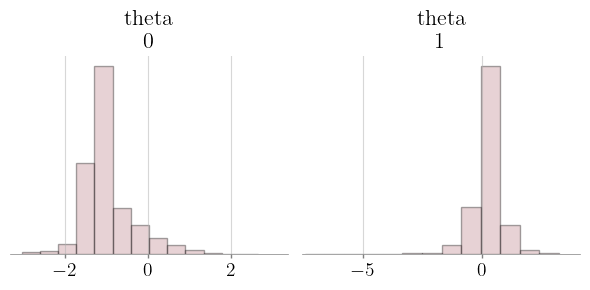

In [25]:
_, axes = plt.subplots(figsize=(6, 3), ncols=2)
sbijax.plot_posterior(inference_results, axes=axes)
plt.tight_layout()
plt.savefig("figs/appendix-mixture_model-npe.pdf", dpi=200)
plt.show()

## NLE

In [26]:
from sbijax import NLE

In [27]:
def make_mdn(hidden_sizes=[50, 50], n_components=10, n_dimension=2):
    
    @hk.transform
    def mdn(method, y, x):
        n = x.shape[0]
        hidden = hk.nets.MLP([50, 50], activate_final=True)(x)
        logits = hk.Linear(n_components)(hidden)
        mu_sigma = hk.Linear(n_components * n_dimension * 2)(hidden)
        mu, sigma = jnp.split(mu_sigma, 2, axis=-1)
        
        mixture = tfd.MixtureSameFamily(
            tfd.Categorical(logits=logits),
                tfd.MultivariateNormalDiag(
                mu.reshape(n, n_components, n_dimension),
                    jnp.exp(sigma.reshape(n, n_components, n_dimension)),
            )
        )
        return mixture.log_prob(y)
    return mdn

In [28]:
fns = prior_fn, simulator_fn
model = NLE(fns, make_mdn())

data, _ = model.simulate_data(jr.PRNGKey(1))
params, info = model.fit(
    jr.PRNGKey(2), 
    data=data,
    optimizer=optax.adam(1e-3),
    n_early_stopping_patience=25,
)

 10%|█████████████▍                                                                                                                              | 96/1000 [00:06<01:00, 14.97it/s]


In [29]:
inference_results, _ = model.sample_posterior(jr.PRNGKey(3), params, y_observed)

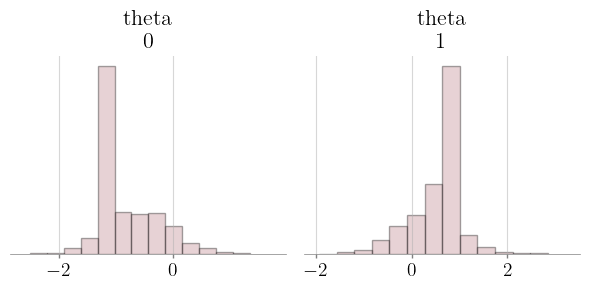

In [30]:
_, axes = plt.subplots(figsize=(6, 3), ncols=2)
sbijax.plot_posterior(inference_results, axes=axes)
plt.tight_layout()
plt.savefig("figs/appendix-mixture_model-nle.pdf", dpi=200)
plt.show()

## Session info

In [31]:
import session_info

session_info.show(html=False)

-----
arviz                       0.19.0
distrax                     0.1.5
haiku                       0.0.12
jax                         0.4.31
jaxlib                      0.4.31
matplotlib                  3.9.2
optax                       0.2.3
sbijax                      1.0.0
session_info                1.0.0
surjectors                  0.3.3
tensorflow_probability      0.25.0-dev20240815
xarray                      2024.7.0
-----
IPython             8.26.0
jupyter_client      8.6.2
jupyter_core        5.7.2
jupyterlab          4.2.4
notebook            7.2.1
-----
Python 3.11.9 | packaged by conda-forge | (main, Apr 19 2024, 18:34:54) [Clang 16.0.6 ]
macOS-13.0.1-arm64-arm-64bit
-----
Session information updated at 2024-08-15 20:39
